In [1]:
import os
import errno
import argparse

import numpy as np
import skimage.io
import skimage.external.tifffile as tiff
import skimage.morphology
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras import backend as K
from scipy import stats

from deepcell import get_image_sizes
from deepcell import make_training_data
from deepcell import bn_feature_net_31x31
from deepcell import dilated_bn_feature_net_31x31
from deepcell import train_model_watershed
from deepcell import train_model_watershed_sample
from deepcell import bn_dense_feature_net
from deepcell import rate_scheduler
from deepcell import train_model_disc, train_model_conv, train_model_sample
from deepcell import run_models_on_directory
from deepcell import export_model
from deepcell import get_data

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# data options
DATA_OUTPUT_MODE = 'sample'
BORDER_MODE = 'valid' if DATA_OUTPUT_MODE == 'sample' else 'same'
RESIZE = True
RESHAPE_SIZE = 2048
N_EPOCHS = 40
WINDOW_SIZE = (15,15)
BATCH_SIZE = 64
MAX_TRAIN = 1e8
BINS = 4

INT_ONLY = True
REMAKE_CONV = False

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'
ROW_AXIS = 2 if IS_CHANNELS_FIRST else 1
COL_AXIS = 3 if IS_CHANNELS_FIRST else 2
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else -1



# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'

PREFIX_SEG = 'tissues/mibi/samir'
PREFIX_CLASS = 'tissues/mibi/mibi_full'
PREFIX_SAVE = 'tissues/mibi/pipeline'
RUN_DIR = 'set1'

TRAIN_DIR_SAMPLE = ['set1', 'set2']
TRAIN_DIR_CLASS_RANGE = range(1, 39+1)

NUM_FEATURES_IN_SEG = 2
NUM_FEATURES_OUT_SEG = 3
NUM_FEATURES_CLASS = 17

In [6]:
FG_BG_DATA_FILE = 'mibi_pipe_wshedFB_{}_{}'.format(K.image_data_format(), DATA_OUTPUT_MODE)
WATERSHED_DATA_FILE = 'mibi_pipe_wshed_{}_{}'.format(K.image_data_format(), DATA_OUTPUT_MODE)
#CONV_DATA_FILE = 'mibi_pipe_wshedconv_{}_{}'.format(K.image_data_format(), 'conv')
CONV_DATA_FILE = 'mibi_watershedconv_{}_{}'.format(K.image_data_format(), 'conv')


In [3]:
MODEL_FGBG = '2018-07-13_mibi_31x31_channels_last_sample__0.h5'
MODEL_WSHED = '2018-08-03_mibi_watershed_channels_last_sample_watershed_0.h5'

CHANNELS_SEG = ['dsDNA', 'Ca', 'H3K27me3', 'H3K9ac', 'Ta']  #Add P?
CHANNELS_CLASS = ['dsDNA', 'Ca', 'H3K27me3', 'H3K9ac', 'Ta', 'FoxP3.', 'CD4.', 'CD16.', 'EGFR.', 'CD68.', 'CD8.', 'CD3.',
                 'Keratin17.', 'CD20.', 'p53.', 'catenin.', 'HLA-DR.', 'CD45.', 'Pan-Keratin.', 'MPO.',
                 'Keratin6.', 'Vimentin.', 'SMA.', 'CD31.', 'CD56.', 'CD209.', 'CD11c.', 'CD11b.']

In [4]:
raw_dir = 'raw'
data_location = os.path.join(DATA_DIR, PREFIX_SEG, RUN_DIR, raw_dir)
output_location = os.path.join(RESULTS_DIR, PREFIX_SEG)
channel_names = CHANNELS_SEG
image_size_x, image_size_y = get_image_sizes(data_location, channel_names)

In [7]:
# define model type
model_fn = dilated_bn_feature_net_31x31
# model names
watershed_weights_file = os.path.join(MODEL_DIR, PREFIX_SEG, MODEL_WSHED)
# weights directories
# fgbg_weights_file = '2018-07-13_mibi_watershedFB_channels_last_sample_fgbg_0.h5'
fgbg_weights_file = os.path.join(MODEL_DIR, PREFIX_SEG, MODEL_FGBG)

# Load the training data from NPZ into a numpy array
testing_data = np.load(os.path.join(NPZ_DIR, PREFIX_SEG, CONV_DATA_FILE + '.npz'))

X, y = testing_data['X'], testing_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# save the size of the input data for input_shape model parameter
#size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[ROW_AXIS:COL_AXIS + 1]
size = X.shape[ROW_AXIS:COL_AXIS + 1]
if IS_CHANNELS_FIRST:
    input_shape = (X.shape[CHANNEL_AXIS], size[0], size[1])
else:
#     input_shape = (size[0], size[1], X.shape[CHANNEL_AXIS])
    input_shape = (size[0], size[1], len(CHANNELS_SEG))

print(IS_CHANNELS_FIRST)
print('input_shape is:', input_shape)

# load weights into both models
run_watershed_model = model_fn(n_features=BINS, input_shape=input_shape)
run_watershed_model.load_weights(watershed_weights_file)
run_fgbg_model = model_fn(n_features=3, input_shape=input_shape)
run_fgbg_model.load_weights(fgbg_weights_file)

# get the data to run models on
training_data_file = os.path.join(NPZ_DIR, PREFIX_SEG, CONV_DATA_FILE + '.npz')
train_dict, (X_test, y_test) = get_data(training_data_file, mode='conv', seed=21)
# run models
test_images = run_watershed_model.predict(X_test)
test_images_fgbg = run_fgbg_model.predict(X_test)

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

argmax_images = []
for i in range(test_images.shape[0]):
    argmax_images.append(np.argmax(test_images[i], axis=CHANNEL_AXIS))
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=CHANNEL_AXIS)

print('watershed argmax shape:', argmax_images.shape)


X.shape: (1, 2048, 2048, 5)
y.shape: (1, 2018, 2018, 3)
False
input_shape is: (2048, 2048, 5)
Using dilated feature net 31x31 with batch normalization
Using dilated feature net 31x31 with batch normalization
watershed transform shape: (1, 2018, 2018, 4)
segmentation mask shape: (1, 2018, 2018, 3)
watershed argmax shape: (1, 2018, 2018, 1)


In [71]:
# threshold the foreground/background
# and remove back ground from watershed transform

edge = test_images_fgbg[:,:,:,0]
edge[edge < 0.3] = 0

int = test_images_fgbg[:, :, :, 1]

fg_thresh = (int - 10*edge) > 0.25

fg_thresh = skimage.morphology.binary_erosion(fg_thresh)
#            fg_thresh = skimage.morphology.binary_dilation(fg_thresh)
#            fg_thresh = skimage.morphology.binary_erosion(fg_thresh)
#            fg_thresh = skimage.morphology.binary_dilation(fg_thresh)
#            fg_thresh = skimage.morphology.binary_erosion(fg_thresh)
#            fg_thresh = skimage.morphology.binary_dilation(fg_thresh)
#            fg_thresh = skimage.morphology.binary_erosion(fg_thresh)
#else:
#    fg_thresh = (test_images_fgbg[:,:,:,0] + test_images_fgbg[:,:,:,1]) > 0.4

fg_thresh = np.expand_dims(fg_thresh, axis=CHANNEL_AXIS)
argmax_images_post_fgbg = argmax_images * fg_thresh


In [72]:
# Apply watershed method with the distance transform as seed
from scipy import ndimage
from skimage.morphology import watershed
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    if IS_CHANNELS_FIRST:
        image = fg_thresh[i, 0, :, :]
        distance = argmax_images_post_fgbg[i, 0, :, :]
    else:
        image = fg_thresh[i, :, :, 0]
        distance = argmax_images_post_fgbg[i, :, :, 0]

    local_maxi = peak_local_max(distance, min_distance=10, indices=False, labels=image)

    markers = ndimage.label(local_maxi)[0]
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=CHANNEL_AXIS)

index = 0

In [93]:
dsDNA = np.copy(X_test[index,:,:,0])
dsDNA = dsDNA[15:-15, 15:-15]

watershed_segmentation = watershed_images[index, :, :, 0]
#wshed_ero = skimage.morphology.erosion(np.copy(watershed_segmentation))
#watershed_segmentation[watershed_segmentation != wshed_ero] = 0

wshed_dil = skimage.morphology.dilation(np.copy(watershed_segmentation))
#wshed_dil = skimage.morphology.dilation(wshed_dil)
#wshed_dil = skimage.morphology.dilation(wshed_dil)
watershed_segmentation = wshed_dil


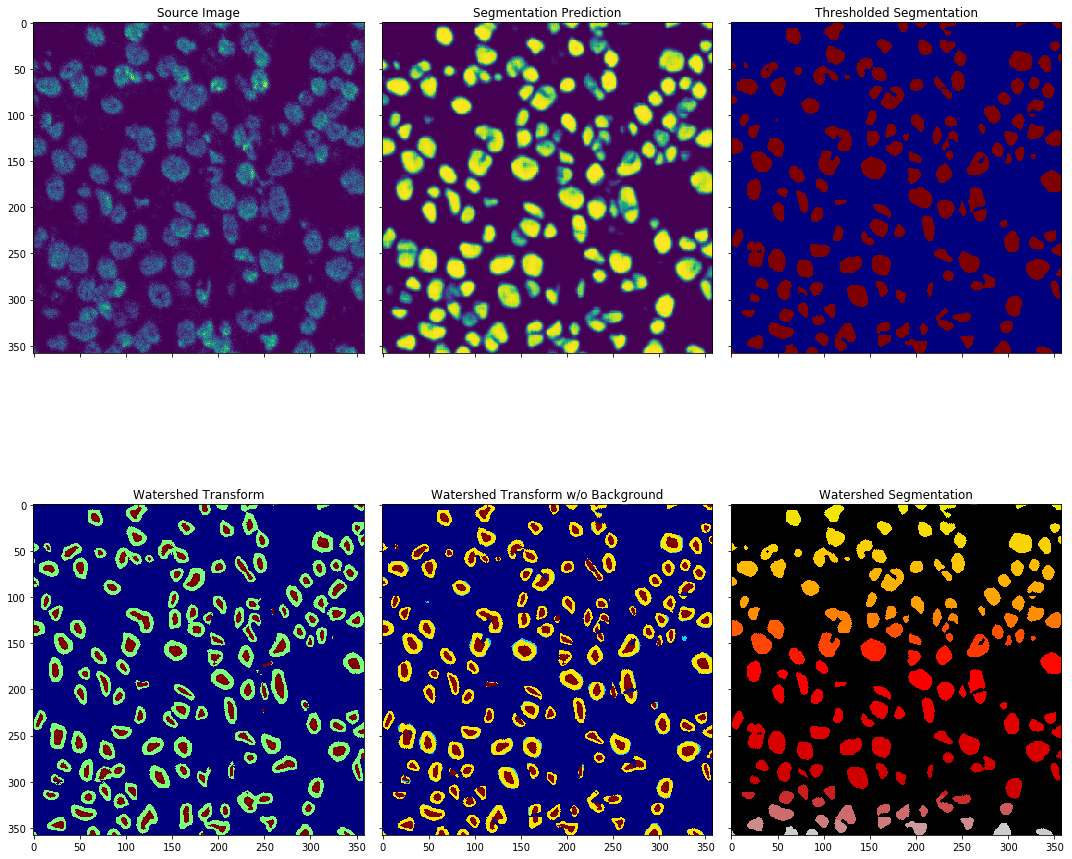

In [94]:
# Plot the results
import matplotlib.pyplot as plt

index = 0

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

winx1 = 830
winx2 = -830

winy1 = 830
winy2 = -830

source = dsDNA
source = source[winy1:winy2, winx1:winx2]
ax[0].imshow(source)
ax[0].set_title('Source Image')


seg_pred = test_images_fgbg[index, :, :, 1]
seg_pred = seg_pred[winy1:winy2, winx1:winx2]
ax[1].imshow(seg_pred)
ax[1].set_title('Segmentation Prediction')

seg_thresh = fg_thresh[index, :, :, 0]
seg_thresh = seg_thresh[winy1:winy2, winx1:winx2]
ax[2].imshow(seg_thresh, cmap='jet')
ax[2].set_title('Thresholded Segmentation')


wshed_trans = argmax_images[index, :, :, 0]
wshed_trans = wshed_trans[winy1:winy2, winx1:winx2]
ax[3].imshow(wshed_trans, cmap='jet')
ax[3].set_title('Watershed Transform')


wshed_nobg = argmax_images_post_fgbg[index, :, :, 0]
wshed_nobg = wshed_nobg[winy1:winy2, winx1:winx2]
ax[4].imshow(wshed_nobg, cmap='jet')
ax[4].set_title('Watershed Transform w/o Background')


wshed_seg = watershed_segmentation
wshed_seg = wshed_seg[winy1:winy2, winx1:winx2]
ax[5].imshow(wshed_seg, cmap='nipy_spectral')
ax[5].set_title('Watershed Segmentation')

fig.tight_layout()
plt.show()

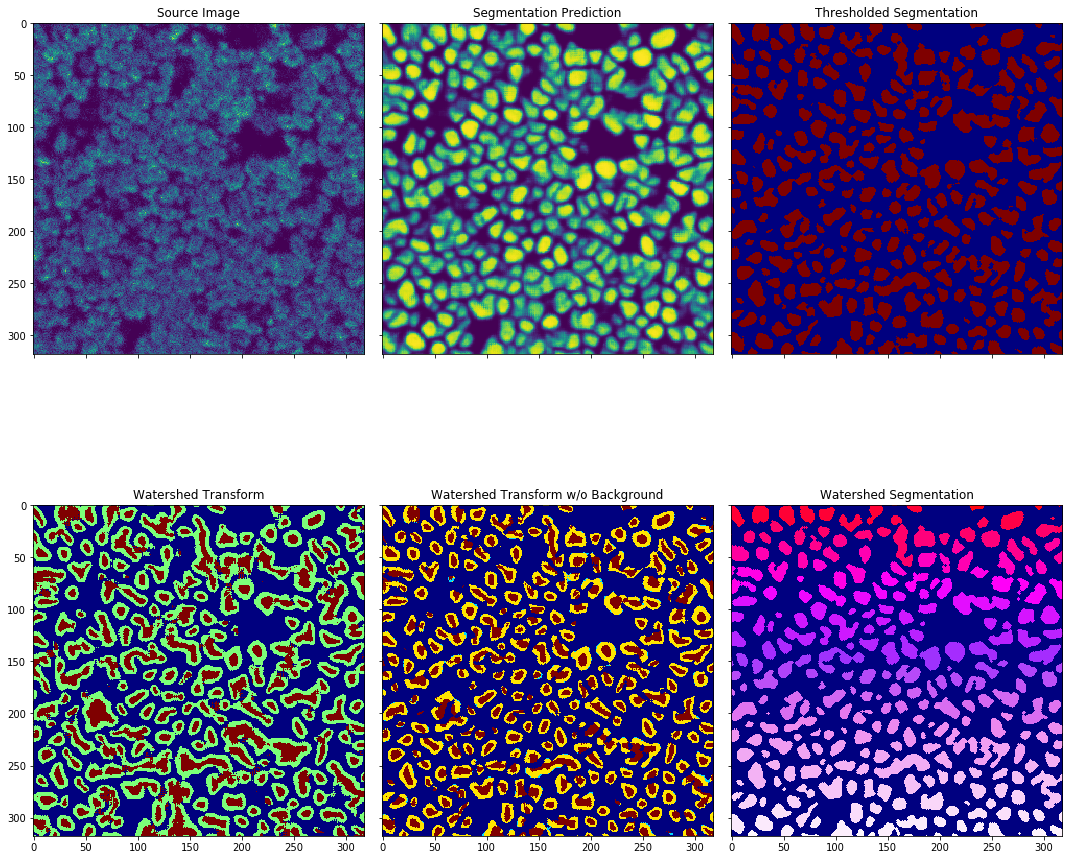

In [95]:
# Plot the results
import matplotlib.pyplot as plt

index = 0

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

winx1 = 850
winx2 = -850

winy1 = 1600
winy2 = -100

source = dsDNA
source = source[winy1:winy2, winx1:winx2]
ax[0].imshow(source)
ax[0].set_title('Source Image')


seg_pred = test_images_fgbg[index, :, :, 1]
seg_pred = seg_pred[winy1:winy2, winx1:winx2]
ax[1].imshow(seg_pred)
ax[1].set_title('Segmentation Prediction')

seg_thresh = fg_thresh[index, :, :, 0]
seg_thresh = seg_thresh[winy1:winy2, winx1:winx2]
ax[2].imshow(seg_thresh, cmap='jet')
ax[2].set_title('Thresholded Segmentation')


wshed_trans = argmax_images[index, :, :, 0]
wshed_trans = wshed_trans[winy1:winy2, winx1:winx2]
ax[3].imshow(wshed_trans, cmap='jet')
ax[3].set_title('Watershed Transform')


wshed_nobg = argmax_images_post_fgbg[index, :, :, 0]
wshed_nobg = wshed_nobg[winy1:winy2, winx1:winx2]
ax[4].imshow(wshed_nobg, cmap='jet')
ax[4].set_title('Watershed Transform w/o Background')


wshed_seg = watershed_segmentation
wshed_seg = wshed_seg[winy1:winy2, winx1:winx2]
ax[5].imshow(wshed_seg, cmap='gist_ncar')
ax[5].set_title('Watershed Segmentation')

fig.tight_layout()
plt.show()